In [1]:
import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


#过采样算法
from imblearn.combine import SMOTEENN
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import SMOTE, ADASYN

#模型验证
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


In [3]:
data=pd.read_excel('C:\\Users\\Administrator\\Desktop\\thesis_shit\\finaldata171819.xlsx')

In [4]:
colname=['code','name','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12',
         'x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x24','x25','x26','x27','x28','x29','x30','x31','x32','y']
data.columns=colname

2275


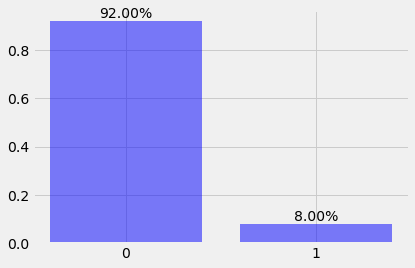

In [5]:
print(data.y.count())
a=data.y[data.y==0].count()/data.y.count()
plt.bar(['0','1'],[a,1-a],alpha=0.5,color='blue')
for a, b, label in zip(['0','1'],[a,1-a],[a,1-a]):
    plt.text(a,
             b,
             format(label,'.02%'),
             ha='center', 
             va='bottom')

In [6]:
data=data.drop(['code','name'],axis=1)

In [7]:
y=data.iloc[:,-1]
X=data.iloc[:,:-1]

In [8]:
len(y)

2275

In [9]:
y.value_counts()

0    2093
1     182
Name: y, dtype: int64

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
data_0=data[data.y==0]
data_1=data[data.y==1]
train_0,test_0=train_test_split(data_0,test_size=0.15,random_state=29)
train_1,test_1=train_test_split(data_1,test_size=0.15,random_state=29)

train0,eva0=train_test_split(train_0,test_size=0.15,random_state=29)
train1,eva1=train_test_split(train_1,test_size=0.15,random_state=29)

train=pd.concat([train0,train1])
eva=pd.concat([eva0,eva1])
test=pd.concat([test_0,test_1])

In [11]:
Xtrain=train.iloc[:,:-1]
ytrain=train.iloc[:,-1]
Xeva=eva.iloc[:,:-1]
yeva=eva.iloc[:,-1]
Xtest=test.iloc[:,:-1]
ytest=test.iloc[:,-1]

In [12]:
from imblearn.over_sampling import SMOTE
#过采样，好坏客户平分
sm = SMOTE(random_state=19,sampling_strategy=0.5)
#sm = SMOTE(random_state=42,sampling_strategy="auto")
#sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(Xtrain, ytrain)
print(y_resampled.value_counts())

0    1512
1     756
Name: y, dtype: int64


In [13]:
print(ytrain.value_counts())
print(y_resampled.value_counts())
print(yeva.value_counts())
print(ytest.value_counts())

0    1512
1     130
Name: y, dtype: int64
0    1512
1     756
Name: y, dtype: int64
0    267
1     24
Name: y, dtype: int64
0    314
1     28
Name: y, dtype: int64


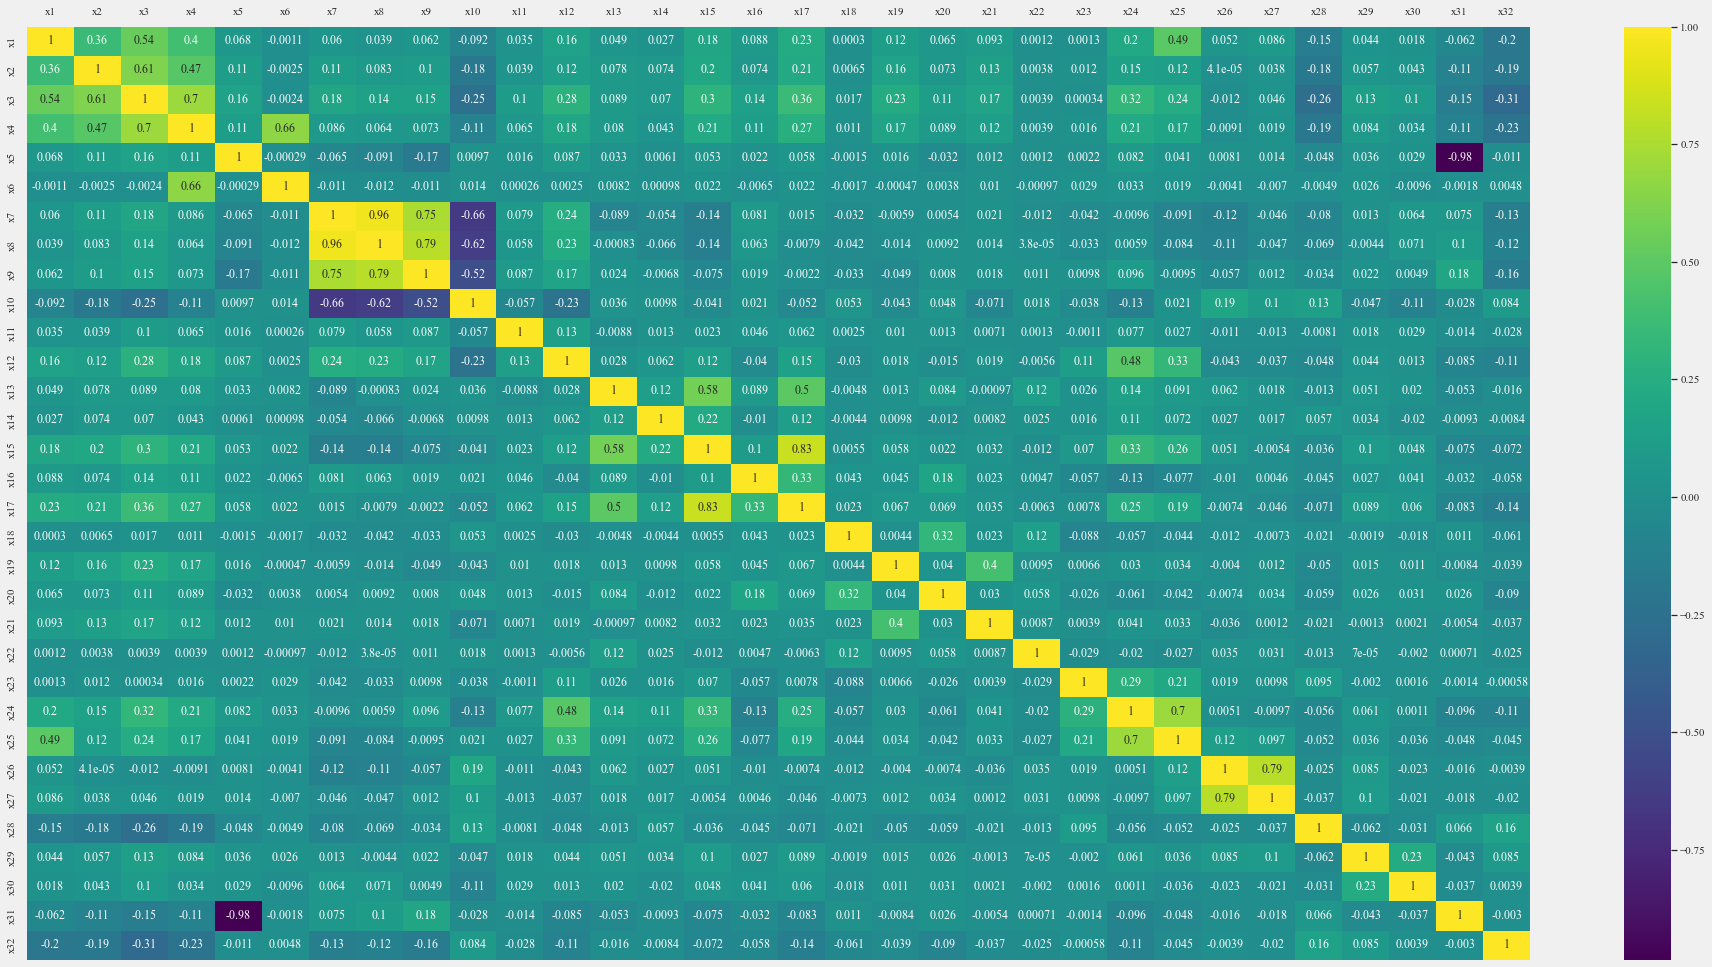

In [14]:
cfit=X_resampled.corr()
fig = plt.figure(figsize = (30,16))
sns.set(font_scale=1)
plt.rc('font',family='Times New Roman',size=12)

ax = sns.heatmap(cfit, cmap="viridis", annot = True)
ax.tick_params(axis='x',labelsize=11, labeltop=True, labelbottom=False)

In [15]:
def drop_corr(X):
    X=X.drop(['x3','x31','x8','x9','x27','x17'],axis=1)
    return X
ytrain=y_resampled
Xtrain=drop_corr(X_resampled)
Xeva=drop_corr(Xeva)

In [16]:
Xtest=drop_corr(Xtest)

In [17]:
"""
def take_X(X):
    X=X[['x5','x6','x13','x19','x23','x25','x26','x33']]
    return X
Xtrain=take_X(X_resampled)
Xeva=take_X(Xeva)
"""


"\ndef take_X(X):\n    X=X[['x5','x6','x13','x19','x23','x25','x26','x33']]\n    return X\nXtrain=take_X(X_resampled)\nXeva=take_X(Xeva)\n"

---------------------------------------Random Forest--------------------------------------------------------

In [20]:
lr_param={'C':[0.01,0.1,0.2,0.5,1,1.5,2],
          'class_weight':[{0: 5, 1: 10}] 
}
lr_gsearch=GridSearchCV(estimator=LogisticRegression(random_state=19,fit_intercept=True,penalty='l2',solver='liblinear'),
                                                    param_grid=lr_param,cv=3,scoring='f1',n_jobs=-1,verbose=2)
lr_gsearch.fit(Xtrain,ytrain)
print(lr_gsearch.best_params_)
y_pred=lr_gsearch.best_estimator_.predict(Xeva)

#测试数据集
print("accuracy on evaluation set:{:.3f}".format(lr_gsearch.best_estimator_.score(Xeva, yeva)))
 
y_true =yeva
 
accuracyScore = accuracy_score(y_true, y_pred)
print('eva accuracy is:',accuracyScore)
 
#precision,TP/(TP+FP) （真阳性）/（真阳性+假阳性）
precision=precision_score(y_true, y_pred)
print('eva precision is:',precision)
 
#recall（sensitive）敏感度，(TP)/（TP+FN）
sensitivity=recall_score(y_true, y_pred)
print('eva sensitivity is:',sensitivity)
  
#F1 = 2 x (精确率 x 召回率) / (精确率 + 召回率)
#F1 分数会同时考虑精确率和召回率，以便计算新的分数。可将 F1 分数理解为精确率和召回率的加权平均值，其中 F1 分数的最佳值为 1、最差值为 0：
f1Score=f1_score(y_true, y_pred)
print("f1_score:",f1Score)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
{'C': 0.01, 'class_weight': {0: 5, 1: 10}}
accuracy on evaluation set:0.918
eva accuracy is: 0.9175257731958762
eva precision is: 0.0
eva sensitivity is: 0.0
f1_score: 0.0


C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
#"""
param_grid = {
    'n_estimators':[500,600],
    'max_features':['sqrt'],
    'max_depth': [20,30,40,10,8],
    'min_samples_leaf': [1,2,4],
    'min_samples_split': [2,3,5],
    'class_weight':[{0:1,1:3},{0:1,1:4},{0:1,1:5},{0:1,1:6}]
}
rf=RandomForestClassifier(random_state=19)
# Instantiate the grid search model
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid,scoring='f1',
                          cv = 3, n_jobs = -1, verbose = 10)
rf_grid.fit(Xtrain, ytrain.values.ravel())
print(rf_grid.best_params_)
y_pred=rf_grid.best_estimator_.predict(Xeva)


#测试数据集
print("accuracy on evaluation set:{:.3f}".format(rf_grid.best_estimator_.score(Xeva, yeva)))
 
y_true =yeva
 
accuracyScore = accuracy_score(y_true, y_pred)
print('eva accuracy is:',accuracyScore)
 
#precision,TP/(TP+FP) （真阳性）/（真阳性+假阳性）
precision=precision_score(y_true, y_pred)
print('eva precision is:',precision)
 
#recall（sensitive）敏感度，(TP)/（TP+FN）
sensitivity=recall_score(y_true, y_pred)
print('eva sensitivity is:',sensitivity)
  
#F1 = 2 x (精确率 x 召回率) / (精确率 + 召回率)
#F1 分数会同时考虑精确率和召回率，以便计算新的分数。可将 F1 分数理解为精确率和召回率的加权平均值，其中 F1 分数的最佳值为 1、最差值为 0：
f1Score=f1_score(y_true, y_pred)
print("f1_score:",f1Score)


Fitting 3 folds for each of 360 candidates, totalling 1080 fits
{'class_weight': {0: 1, 1: 3}, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 600}
accuracy on evaluation set:0.907
eva accuracy is: 0.9072164948453608
eva precision is: 0.4
eva sensitivity is: 0.25
f1_score: 0.3076923076923077


In [107]:
fpr,tpr,thresholds=roc_curve(yeva,y_pred)
roc_auc=auc(fpr,tpr)
ks=max(tpr-fpr)
ar=2*roc_auc-1
gini=ar
print('ks is',ks)
print('gini is',gini)

ks is 0.49672284644194753
gini is 0.4967228464419473


AUC: 0.8795255930087391


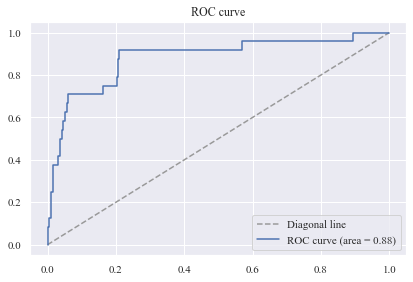

In [108]:
#"""
proba_bad=rf_grid.best_estimator_.predict_proba(Xeva)
y_scores=pd.DataFrame(proba_bad)[1]
y_scores=np.array(y_scores)
#auc分数
#auc分数有两种计算方式，第一种是根据目标变量y_true,预测分数/预测概率y_socres,通过roc_auc_score(y_true, y_scores)计算AUC
AUC=roc_auc_score(y_true, y_scores)
print("AUC:",AUC)
#auc第二种方法是通过fpr,tpr，通过auc(fpr,tpr)来计算AUC
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores, pos_label=1)
AUC1 = auc(fpr,tpr) ###计算auc的值
           
#绘制ROC曲线
#画对角线
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Diagonal line')
plt.plot(fpr,tpr,label='ROC curve (area = %0.2f)' % AUC)
plt.title('ROC curve') 
plt.legend(loc="lower right")  


In [80]:
#change the threshold
rfc=RandomForestClassifier( n_estimators=500,class_weight={0: 5, 1: 10},max_depth=20, max_features='sqrt',
                           min_samples_leaf=2, min_samples_split=2,random_state=19)
rfc.fit(Xtrain, ytrain.values.ravel())
proba_pred=rfc.predict_proba(Xeva)
y_pred=rfc.predict(Xeva)
y_true =yeva

# Print the test scores again: do you find improvements
print(accuracy_score(y_true,y_pred))
print(precision_score(y_true, y_pred))
print(recall_score(y_true, y_pred))
print(f1_score(y_true,y_pred))

0.9072164948453608
0.4117647058823529
0.2916666666666667
0.34146341463414637


In [57]:
fpr,tpr,thresholds=roc_curve(ytest,y_pred)
roc_auc=auc(fpr,tpr)
ks=max(tpr-fpr)
ar=2*roc_auc-1
gini=ar
print('ks is',ks)
print('gini is',gini)

ks is 0.4324385805277525
gini is 0.43243858052775264


AUC: 0.828707916287534


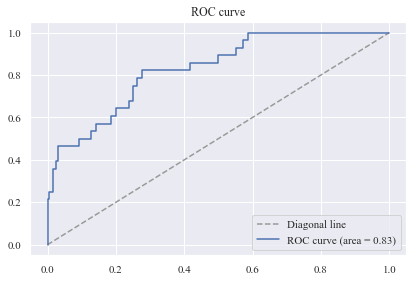

In [58]:

y_scores=pd.DataFrame(proba_pred)[1]
y_scores=np.array(y_scores)
#auc分数
#auc分数有两种计算方式，第一种是根据目标变量y_true,预测分数/预测概率y_socres,通过roc_auc_score(y_true, y_scores)计算AUC
AUC=roc_auc_score(y_true, y_scores)
print("AUC:",AUC)
#auc第二种方法是通过fpr,tpr，通过auc(fpr,tpr)来计算AUC
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores, pos_label=1)
AUC1 = auc(fpr,tpr) ###计算auc的值
           
#绘制ROC曲线
#画对角线
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Diagonal line')
plt.plot(fpr,tpr,label='ROC curve (area = %0.2f)' % AUC)
plt.title('ROC curve') 
plt.legend(loc="lower right")  

In [61]:
num_thresholds=200
accuracy_score_threshold=np.zeros((num_thresholds,))
f1_score_threshold=np.zeros((num_thresholds,))
precision_threshold=np.zeros((num_thresholds,))
sensitivity_threshold=np.zeros((num_thresholds,))
ks_threshold=np.zeros((num_thresholds,))
## Start Coding Here ##

# Generate a grid of thresholds between 0.3 and 0.6
threshold_range=np.linspace(0.3,0.6,num_thresholds)

# Compute the test scores for all thresholds
for i in range(num_thresholds): #注意这里不要用in threshold_range，因为后面赋值的时候用的是索引
    Y_pred=proba_pred[:,1]>threshold_range[i]  
    accuracy_score_threshold[i]=accuracy_score(ytest,Y_pred)
    f1_score_threshold[i]=f1_score(ytest,Y_pred)
    precision_threshold[i]=precision_score(y_true, Y_pred)
    sensitivity_threshold[i]=recall_score(y_true, Y_pred)
    fpr,tpr,thresholds=roc_curve(ytest,Y_pred)
    roc_auc=auc(fpr,tpr)
    ks_threshold[i]=max(tpr-fpr)

In [62]:
index=np.argmax(f1_score_threshold)
best_threshold=threshold_range[index]

In [63]:
print(best_threshold)
print(accuracy_score_threshold[index])
print(f1_score_threshold[index])
print(precision_threshold[index])
print(sensitivity_threshold[index])
print(ks_threshold[index])

0.49597989949748744
0.9269005847953217
0.5098039215686274
0.5652173913043478
0.4642857142857143
0.4324385805277525


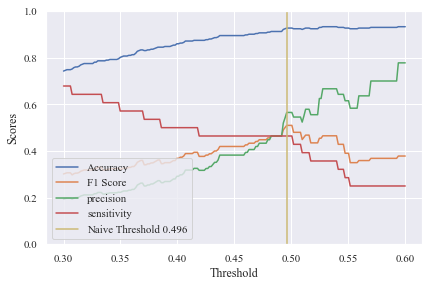

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(
    threshold_range,
    accuracy_score_threshold,
    label='Accuracy'
)

ax.plot(
    threshold_range,
    f1_score_threshold,
    label='F1 Score'
)

ax.plot(
    threshold_range,
    precision_threshold,
    label='precision'
)

ax.plot(
    threshold_range,
    sensitivity_threshold,
    label='sensitivity'
)


plt.axvline(x = best_threshold, color = 'y', label =  f'Naive Threshold {round(best_threshold,3)}')

ax.set_ylim((0.0, 1))
ax.set_xlabel("Threshold")
ax.set_ylabel("Scores")

leg = ax.legend(loc="lower left", fancybox=True)

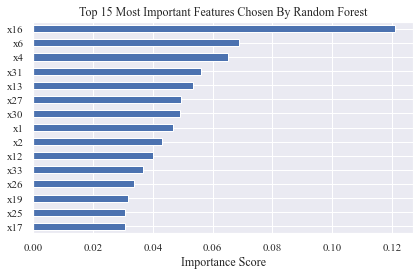

In [114]:
feature_names = list(Xtrain.columns)

feature_importances = pd.Series(
    rfc.feature_importances_, index=feature_names
).sort_values(ascending=True)

ax = feature_importances.iloc[-15:].plot.barh()
ax.set_title("Top 15 Most Important Features Chosen By Random Forest")
ax.set_xlabel("Importance Score")
ax.figure.tight_layout()



feature_importances=forest.feature_importances_
names=Xtrain.columns
list_feature_importances=list(zip(feature_importances,names))
df_feature_importances=pd.DataFrame(list_feature_importances)
df_feature_importances.to_excel("C:\\Users\Administrator\\Desktop\\RF变量信息增益.xlsx")
